In [19]:
import torch
torch.autograd.set_detect_anomaly(True)
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, global_max_pool, GlobalAttention,GATv2Conv
from torchvision import transforms
import timm
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        model = timm.create_model(
    "vit_large_patch16_224", img_size=224, patch_size=16, init_values=1e-5, num_classes=0, dynamic_img_size=True
)
        model.load_state_dict(torch.load(("D:/Downloads/crunch/WiKG/pytorch_model.bin")), strict=True)
        # model.load_state_dict(torch.load(("D:/Downloads/pytorch_model.bin"), map_location="cuda:0"), strict=True)
        self.model=model
        # self.model = nn.Sequential(*list(self.model.children())[:-1])

        for p in self.model.parameters():
            p.requires_grad = False

    def forward(self, x):
        x=x.unsqueeze(0)
        # print(x.shape)
        x = self.model(x)
        
        return x

model = ImageEncoder()

In [1]:
import os
import spatialdata as sd
dir = f'D:/data/crunch_large/data/'
# dir=f'F:/DATA/crunch_large/zip_server'
sample_names = ['DC1','DC5', 'UC1_I', 'UC1_NI', 'UC6_I', 'UC6_NI', 'UC7_I', 'UC9_I']
# names = sample_names[2:]
pre_load_path= './pre_load'
os.makedirs(pre_load_path, exist_ok=True)
name= sample_names[3]
sdata = sd.read_zarr(f"{dir}/{sample_names[2]}.zarr")

E:\conda\envs\thitogene\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
import pickle
sample_names = ['DC1','DC5', 'UC1_I', 'UC1_NI', 'UC6_I', 'UC6_NI', 'UC7_I', 'UC9_I']

with open(f'./pre_load/{sample_names[0]}_cells.pkl','rb') as f:
                cell_list= pickle.load(f)

for i  in range(len(cell_list)):
    cell_list[i]['center']=[int(cell_list[i]['center'][1]), int(cell_list[i]['center'][0])]    

In [6]:
with open(f'./pre_load/DC1_cells.pkl','wb') as f:
#     sdata = sd.read_zarr(f"{dir}/{NAMES[0]}.zarr")
#     cell_list=[]
#     for props in tqdm( regionprops(sdata['HE_nuc_registered'][0, :, :].to_numpy()) ):
#         cell_item={}
#         cell_item['cell_id']= props.label
#         centroid = props.centroid
#         cell_item['center']=[int(centroid[1]), int(centroid[0])]
#         cell_list.append(cell_item)
    pickle.dump(cell_list,f)

In [4]:
from tqdm import tqdm
from skimage.measure import regionprops

for props in tqdm( regionprops(sdata['HE_nuc_registered'][0, :, :].to_numpy()) ):
    break

  0%|                                                                                                                                                               | 0/234356 [00:00<?, ?it/s]


In [5]:
props.label, props.centroid

(1, (4485.746341463415, 15923.49756097561))

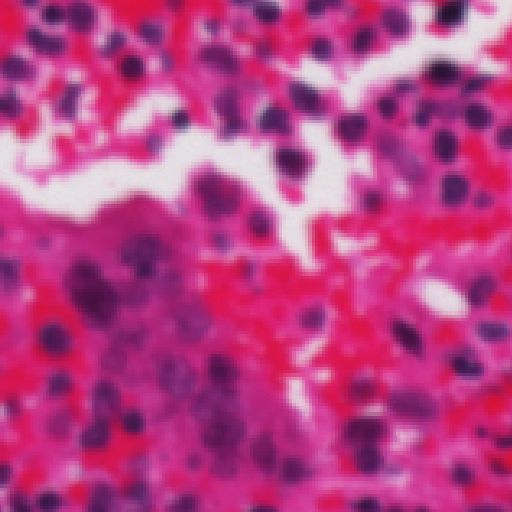

In [ ]:
from PIL import Image 
import numpy as np
x,y=6168,16025
r=256
img3=Image.fromarray(np.transpose(sdata['HE_registered'][:,x-r:x+r,y-r:y+r].to_numpy(),(2,1,0))).resize((512,512))
img3

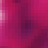

In [3]:
from PIL import Image 
import numpy as np
x1,y1=4485,15923
x2,y2= 4462, 15954
r=24
img1=Image.fromarray(np.transpose(sdata['HE_registered'][:,x1-r:x1+r,y1-r:y1+r].to_numpy(),(2,1,0)))
img2=Image.fromarray(np.transpose(sdata['HE_registered'][:,x2-r:x2+r,y2-r:y2+r].to_numpy(),(2,1,0)))
img1

In [66]:
import torchvision.transforms as transforms

transforms = transforms.Compose([
            # transforms.ColorJitter(0.2, 0.2, 0.2),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomRotation(degrees=180),
            transforms.ToTensor()
        ])
sum_mean=[]
t_img1= transforms(img1)
t_img2= transforms(img2)
t_img3= transforms(img3)
em1= model(t_img1)
em2= model(t_img2)
em3= model(t_img3)

In [71]:
start, end= 150,160
em1[:,start: end],em2[:,start: end],em3[:,start: end]

(tensor([[-1.0909, -0.9846, -0.3259, -1.2765,  0.4557,  1.7113, -1.2481,  0.5504,
          -0.7052,  1.0250]]),
 tensor([[-1.0156, -2.7659, -0.6101, -0.6965,  0.4641,  2.3724, -2.0680, -0.1780,
          -0.0709,  0.5341]]),
 tensor([[ 3.7363, -0.5436,  1.1490,  1.6315,  0.1923,  1.0567, -0.9535,  1.7786,
          -0.8925,  0.1732]]))

In [29]:
em1= model(t_img1)
em2= model(t_img2)
torch.mean(abs(em1-em2))

tensor(0.7267)

In [84]:
import pickle
with open('./mclstexp/pred.pkl','rb') as f:
    pred= pickle.load(f)
with open('./mclstexp/true.pkl','rb') as f:
    true= pickle.load(f)  

In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

test= np.array([0.04]*true[0].shape[0])
mse= mean_squared_error(test,true[0])
mse


0.13055957826293024

###########################################

In [ ]:
import numpy as np
import time

# time.sleep(200)
NAMES = ['DC1','DC5', 'UC1_I', 'UC1_NI', 'UC6_I', 'UC6_NI', 'UC7_I', 'UC9_I']
feature_list=[]
exps_list=[]
dir='D:/Downloads/crunch/WiKG'
group='train'
for name in NAMES[1:]:
    data= np.load(f'{dir}/preprocessed_{name}_{group}.npz')
    feature_list.append(data['features'])
    exps_list.append(data['exps'])
features= np.vstack(feature_list)
exps= np.vstack(exps_list)
np.savez(f'{dir}/preprocessed_{group}.npz', features=features, exps=exps)

In [113]:
np.savez(f'{dir}/preprocessed_{group}.npz', features=features, exps=exps)

In [13]:
import pickle
pre_load_path= './pre_load'
    
with open(f'{pre_load_path}/UC7_I_cells.pkl','rb') as f:
            cell_list= pickle.load(f)

In [118]:
!python preload.py

E:\conda\envs\thitogene\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
E:\conda\envs\thitogene\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
E:\conda\envs\thitogene\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
E:\conda\envs\thitogene\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
E:\conda\envs\thitogene\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModifi

In [117]:
len(np.array([]))

0

In [73]:
import spatialdata as sd

dir = f'D:/data/crunch_large/data/'
NAMES=['DC5', 'UC1_I', 'UC1_NI', 'UC6_I', 'UC6_NI', 'UC7_I', 'UC9_I']
name=NAMES[6]
sdata = sd.read_zarr(f"{dir}/{name}.zarr")


E:\conda\envs\thitogene\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [74]:
cell_id_group=sdata['cell_id-group']
    
anucleus= sdata['anucleus']
sdata=None

cell_id_train =  cell_id_group.obs[ cell_id_group.obs['group'] == 'train']['cell_id'].to_numpy()
# cell_id_train = list(set(cell_id_train).intersection(set( anucleus.obs['cell_id'].unique())))

cell_id_test= cell_id_group.obs[ cell_id_group.obs['group'] == 'test']['cell_id']
cell_id_validation= cell_id_group.obs[ cell_id_group.obs['group'] == 'validation']['cell_id']
max_len= max(max(cell_id_train),max(cell_id_test),max(cell_id_validation))
bool_list= [0]*(max_len+1)
for id in cell_id_train:
    bool_list[id]=1
for id in cell_id_test:
    bool_list[id]=2
for id in cell_id_validation:
    bool_list[id]=3

In [75]:
id=anucleus.obs['cell_id'].to_numpy()
for i in range(len(cell_id_train)):
    if id[i]!= cell_id_train[i]:
        print(i)

In [111]:
import pickle
name = 'DC1'
cluster_path='E:/DATA/crunch/tmp'
cluster_dir=f'{cluster_path}/cluster/train/cluster_data_split'
with open(f'{cluster_dir}/{name}_cells.pkl','rb') as f:
                cell_list_cluster_new = pickle.load(f)

In [112]:
cluster_path='D:/DATA/Gene_Expression/crunch/Register'
cluster_dir=f'{cluster_path}/cluster/train/cluster_data_split'
with open(f'{cluster_dir}/{name}_cells.pkl','rb') as f:
                cell_list_cluster = pickle.load(f)

In [113]:
len(cell_list_cluster),len(cell_list_cluster_new)
new=cell_list_cluster_new['counts'].to_numpy()
cr= cell_list_cluster['counts'].to_numpy()
for i in range(len(new)):
    if sum(new[i]-cr[i])!=0:
        print(i)

In [114]:
idx=1000
x_n=cell_list_cluster_new['x'].to_numpy()[idx]
y_n=cell_list_cluster_new['y'].to_numpy()[idx]
x_n,y_n


(14971, 18505)

In [ ]:

x=cell_list_cluster['x'].to_numpy()[idx]
y=cell_list_cluster['y'].to_numpy()[idx]
x=int(x)
y=int(y)
x,y# 47657: 51136 18000,22000

(7714, 4093)

In [116]:
import spatialdata as sd

dir = f'F:/DATA/crunch_large/submit/data'
# NAMES=['DC5', 'UC1_I', 'UC1_NI', 'UC6_I', 'UC6_NI', 'UC7_I', 'UC9_I']
# name=NAMES[6]
sdata_new = sd.read_zarr(f"{dir}/{name}.zarr")

E:\conda\envs\thitogene\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
E:\conda\envs\thitogene\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [117]:
dir = f'F:/DATA/crunch_large//data'
sdata = sd.read_zarr(f"{dir}/{name}.zarr")

E:\conda\envs\thitogene\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [118]:
from PIL import Image
import numpy as np

In [ ]:
sdata['HE_nuc_registered']

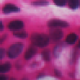

In [119]:
r=80
img=Image.fromarray(np.transpose(sdata['HE_registered'][:,y-r:y+r,x-r:x+r].to_numpy(),(2,1,0))).resize((80,80))
img


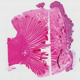

In [39]:
img_all=Image.fromarray(np.transpose(sdata['HE_registered'][:,:,:].to_numpy(),(2,1,0))).resize((80,80))
img_all


In [66]:
sdata['HE_nuc_registered']

<xarray.DataArray 'image' (c: 1, y: 47657, x: 51136)> Size: 10GB
dask.array<from-zarr, shape=(1, 47657, 51136), dtype=uint32, chunksize=(1, 5792, 5792), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int32 4B 0
  * y        (y) float64 381kB 0.5 1.5 2.5 3.5 ... 4.765e+04 4.766e+04 4.766e+04
  * x        (x) float64 409kB 0.5 1.5 2.5 3.5 ... 5.113e+04 5.113e+04 5.114e+04
Attributes:
    transform:  {'global': Identity }

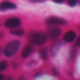

In [120]:
r=24
img_new=Image.fromarray(np.transpose(sdata_new['HE_original'][:,x_n-r:x_n+r,y_n-r:y_n+r].to_numpy(),(2,1,0))).resize((80,80))
# img_new=Image.fromarray(np.transpose(sdata_new['HE_original'][:,y_n-r:y_n+r,x_n-r:x_n+r].to_numpy(),(2,1,0))).resize((80,80))
# 
img_new.transpose(method=Image.FLIP_LEFT_RIGHT).transpose(method=Image.FLIP_TOP_BOTTOM)

In [100]:
import torch.nn as nn
import timm
import torch
class ImageEncoder(nn.Module):
    def __init__(self,resources_path):
        super().__init__()
        model = timm.create_model(
    "vit_large_patch16_224", img_size=224, patch_size=16, init_values=1e-5, num_classes=0, dynamic_img_size=True
)
        pretrain_model_path=f'{resources_path}/pytorch_model.bin'
        model.load_state_dict(torch.load((f'{pretrain_model_path}')), strict=True)
        # model.load_state_dict(torch.load(("D:/Downloads/pytorch_model.bin"), map_location="cuda:0"), strict=True)
        self.model=model
        # self.model = nn.Sequential(*list(self.model.children())[:-1])

        for p in self.model.parameters():
            p.requires_grad = False

    def forward(self, x):
        # x=x.unsqueeze(0) # for testing single image
        # print(x.shape)
        x = self.model(x)

        return x
# pretrain_model_path='./resources/pytorch_model.bin'
resources_path='C:/DATA/Crunch/submit/resources'
encoder= ImageEncoder(resources_path=resources_path)
encoder.eval()
encoder=encoder.to('cuda')
import torchvision.transforms as transforms

t_n=transforms.ToTensor()(img_new)
t= transforms.ToTensor()(img)

In [102]:
emb_n= encoder(t_n.unsqueeze(0).to('cuda'))
emb= encoder(t.unsqueeze(0).to('cuda'))

In [108]:
sum(emb[0]-emb_n[0])

tensor(18.2270, device='cuda:0')

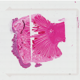

In [42]:
img_new_all=Image.fromarray(np.transpose(sdata_new['HE_original'][:,:,:].to_numpy(),(2,1,0))).resize((80,80))
img_new_all

In [43]:
sdata_new['HE_original']

<xarray.DataArray 'image' (c: 3, y: 18000, x: 22000)> Size: 1GB
dask.array<from-zarr, shape=(3, 18000, 22000), dtype=uint8, chunksize=(3, 6688, 6688), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int32 12B 0 1 2
  * y        (y) float64 144kB 0.5 1.5 2.5 3.5 ... 1.8e+04 1.8e+04 1.8e+04
  * x        (x) float64 176kB 0.5 1.5 2.5 3.5 ... 2.2e+04 2.2e+04 2.2e+04
Attributes:
    transform:  {'global': Identity }

In [57]:
sdata_new

SpatialData object, with associated Zarr store: F:\Data\crunch_large\submit\data\DC5.zarr
├── Images
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 18000, 22000)
│     └── 'HE_original': DataArray[cyx] (3, 18000, 22000)
└── Tables
      ├── 'anucleus': AnnData (140368, 460)
      └── 'cell_id-group': AnnData (171019, 0)
with coordinate systems:
    ▸ 'global', with elements:
        HE_nuc_original (Images), HE_original (Images)

In [30]:
new=cell_list_cluster_new['cell_id'].to_numpy()
cr= cell_list_cluster['cell_id'].to_numpy()
for i in range(len(new)):
    if new[i]-cr[i]!=0:
        print(i)

In [32]:
cr[0]

6

In [76]:
import pickle
pre_load_path= './pre_load'
with open(f'./pre_load/{name}_cells.pkl','rb') as f:
            cell_list= pickle.load(f)
split_path= "./WiKG//train_split"
with open(f'{split_path}/{name}_train.pkl','rb') as f:  # Python 3: open(..., 'rb')
                split_train_binary = pickle.load(f)

In [77]:
import numpy as np
amax= max(cell_id_train)+1
index_list= np.array([0]*amax)
i=0
for id in cell_id_train:
    index_list[id]= i
    i+=1

In [79]:
check_bin=0
train=True
train=False
count=0
for props in cell_list:
            count+=1
            cell_id= props['cell_id']
            # if cell_id >= len( self.sdata_dict[i]['anucleus'].layers['counts']):
            #     continue
            flag= True
            if cell_id >= len(bool_list) or bool_list[cell_id] !=1:
                flag =False
        
            if flag == False :
                continue
            # if flag == True   and self.train==False:
            #     continue
            if check_bin >=len(split_train_binary):
                break
            if (split_train_binary[check_bin] ==0 and train==True) or\
                (split_train_binary[check_bin] ==1 and train==False):
                check_bin+=1
                continue
            if check_bin!=index_list[cell_id]:
                print(i)
            check_bin+=1
            
            centroid = props['center']
            # center_list.append([int(centroid[1]), int(centroid[0])])
            # cell_id_list.append(int(cell_id))  

In [30]:
check_bin,len(split_train_binary),flag,cell_id,count
# if cell_id >= len(bool_list) or bool_list[cell_id] !=1:
#     print('a')
cell_list[1906]['cell_id']
if cell_id >= len(bool_list) or bool_list[cell_id] !=1:
                flag ==False
                print(flag)

True


In [121]:
len(cell_list),anucleus.shape,cell_list[0]

(277046,
 (144704, 460),
 {'center': (4219.004975124378, 9709.39800995025),
  'cell_id': 1,
  'label': 'train',
  'anucleus': array([1.3606049 , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.89579225, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.89579225, 0.        ,
         0.89579225, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0. 

In [93]:
bool_list[1],max_len,len(cell_id_train),len(cell_id_validation)


(1, 338345, 144704, 22334)

In [104]:
for i in range(len(cell_list)):
        cell_id= cell_list[i]['cell_id']
        centroid = cell_list[i]['center']
        if cell_id >= len(bool_list):
            cell_list[i]['label']='None'
            continue
        elif bool_list[cell_id] ==1:
            
            cell_list[i]['label']='train'
            # print(props)
        elif bool_list[cell_id] ==2:
            cell_list[i]['label']='test'
        elif bool_list[cell_id] ==3:
            cell_list[i]['label']='validation'
        else:
            cell_list[i]['label']='None'

In [105]:
# cell_list[0]['label']='train'
cell_list

[{'center': (4219.004975124378, 9709.39800995025),
  'cell_id': 1,
  'label': 'train'},
 {'center': (4443.799342105263, 9159.470394736842),
  'cell_id': 3,
  'label': 'train'},
 {'center': (4461.628125, 9941.496875), 'cell_id': 4, 'label': 'train'},
 {'center': (4295.973684210527, 9659.07105263158),
  'cell_id': 5,
  'label': 'train'},
 {'center': (4395.339325842697, 9216.555056179775),
  'cell_id': 6,
  'label': 'train'},
 {'center': (4430.546783625731, 9268.43274853801),
  'cell_id': 7,
  'label': 'train'},
 {'center': (4341.645640074212, 9212.205936920223),
  'cell_id': 8,
  'label': 'train'},
 {'center': (4466.89247311828, 9061.897849462366),
  'cell_id': 10,
  'label': 'train'},
 {'center': (4437.130434782609, 9194.673913043478),
  'cell_id': 11,
  'label': 'train'},
 {'center': (4374.898419864559, 9273.395033860044),
  'cell_id': 12,
  'label': 'train'},
 {'center': (4361.878787878788, 9633.764568764569),
  'cell_id': 13,
  'label': 'train'},
 {'center': (4287.22629969419, 9623.7

In [108]:
filtered_cells = [c for c in cell_list if c['label'] == 'train']

In [109]:
filtered_cells

[{'center': (4219.004975124378, 9709.39800995025),
  'cell_id': 1,
  'label': 'train'},
 {'center': (4443.799342105263, 9159.470394736842),
  'cell_id': 3,
  'label': 'train'},
 {'center': (4461.628125, 9941.496875), 'cell_id': 4, 'label': 'train'},
 {'center': (4295.973684210527, 9659.07105263158),
  'cell_id': 5,
  'label': 'train'},
 {'center': (4395.339325842697, 9216.555056179775),
  'cell_id': 6,
  'label': 'train'},
 {'center': (4430.546783625731, 9268.43274853801),
  'cell_id': 7,
  'label': 'train'},
 {'center': (4341.645640074212, 9212.205936920223),
  'cell_id': 8,
  'label': 'train'},
 {'center': (4466.89247311828, 9061.897849462366),
  'cell_id': 10,
  'label': 'train'},
 {'center': (4437.130434782609, 9194.673913043478),
  'cell_id': 11,
  'label': 'train'},
 {'center': (4374.898419864559, 9273.395033860044),
  'cell_id': 12,
  'label': 'train'},
 {'center': (4361.878787878788, 9633.764568764569),
  'cell_id': 13,
  'label': 'train'},
 {'center': (4287.22629969419, 9623.7

In [124]:
name = 'UC7_I'
with open(f'./cluster/cluster_data_split/{name}_cell.pkl','rb') as f:
        cell_locations=pickle.load(f)

In [135]:
exps_list= [exp['anucleus'] for exp in cell_list if len(exp['anucleus'])>0]

In [137]:
len(exps_list),cell_locations

(144704,
                    x             y  cluster  train  \
 0        9709.398010   4219.004975     2195      1   
 1        9159.470395   4443.799342     5573      1   
 2        9941.496875   4461.628125      473      1   
 3        9659.071053   4295.973684     2195      1   
 4        9216.555056   4395.339326     2194      1   
 ...              ...           ...      ...    ...   
 144699  31409.274554  40435.042411     3270      0   
 144700  31256.619048  40400.365079      819      1   
 144701  31579.061594  40421.155797     3270      0   
 144702  31592.526829  40503.321951     3270      0   
 144703  31281.826923  40384.173077      819      1   
 
                                                      exps  
 0       [1.3606049, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
 1       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.638...  
 2       [1.5936273, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
 3       [1.7318614, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
 4       [0.0, 0.0, 0.0,

In [136]:
cell_locations['exps']=exps_list